In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Tokenizing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import spacy

# Vectorizer/Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import tensorflow_hub as hub

# Own Python Functions
from utilities import load_data_basic_cleanup

# Flag to use Backup-Pickle-data or recalculate all data
flag_load_backup = True

# Flag depending if Pickle-Files exist
flag_tokens = False
flag_designmatrix = False
if os.path.exists('tokens.dat'):
    flag_tokens = True
if os.path.exists('designmatrix.dat'):
    flag_designmatrix = True

# Load Data
Read Data, primary label assignment, and basic data cleanup

In [2]:
if not (flag_load_backup and flag_tokens):
    # Get data. Primary Topic
    df = load_data_basic_cleanup()

# Preprocessing

## Tokenization

Remove Stopwords, Tokenization and Stemmer
**Tokenization** with Nltk and SpaCy


In [31]:
if not (flag_load_backup and flag_tokens):
    # NLTK
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')
    nltk_stopwords = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    def preprocess_text(text):
        # Tokenization
        tokens = word_tokenize(text.lower())  # Lowercasing and tokenizing
        # Removing stop words and non-alphabetical characters
        filtered_tokens = [word for word in tokens if word.isalpha() and word not in nltk_stopwords]
        # Applying stemming on the filtered tokens
        stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
        return  " ".join(stemmed_tokens)

    df['DESCRIPTION_CLEAN_NLTK'] = df['DESCRIPTION'].apply(preprocess_text)

In [32]:
if not (flag_load_backup and flag_tokens):
    # Spacy
    nlp = spacy.load("en_core_web_sm")
    spacy_stopwords = set(nlp.Defaults.stop_words)
    def preprocess_text(text):
        # Tokenization
        doc = nlp(text.lower())  # Lowercasing and tokenizing
        # Removing stop words and non-alphabetical characters
        tokens = [token.text for token in doc if token.text.lower() not in spacy_stopwords and not token.is_punct]
        return " ".join(tokens)

    df['DESCRIPTION_CLEAN_SPACY'] = df['DESCRIPTION'].apply(preprocess_text)

In [13]:
if not (flag_load_backup and flag_tokens):
    # Write Data
    with open(f'tokens.dat', 'wb') as f:
        pickle.dump(df, f)
if (flag_load_backup and flag_tokens) and not flag_designmatrix:
    # Read Data
    with open(f'tokens.dat', 'rb') as f:
        df = pickle.load(f)

## Vectorizing and Embedding

Vectorizing with TF-IDF
Word Embedding with Doc2Vec and Universal Sentence Encoder

In [14]:
#Tfidf Vectorizer
if not (flag_load_backup and flag_designmatrix):
    vectorizer = TfidfVectorizer(
        max_features=1024,
        stop_words='english',
        ngram_range=(1, 2)
    )
    X_tfidf_nltk = vectorizer.fit_transform(df['DESCRIPTION_CLEAN_NLTK'])
    X_tfidf_spacy = vectorizer.fit_transform(df['DESCRIPTION_CLEAN_SPACY'])

    print(f"TF-IDF matrix shape: {X_tfidf_nltk.shape}")
    print("Sample feature names:", vectorizer.get_feature_names_out()[:10])

TF-IDF matrix shape: (91893, 1024)
Sample feature names: ['000' '10' '100' 'ability' 'able' 'accessible' 'acclaimed' 'account'
 'act' 'action']


In [15]:
# Doc2Vec
if not (flag_load_backup and flag_designmatrix):
    def calc_doc2vec(column):
        # Create TaggedDocuments
        tagged_data = [TaggedDocument(words=row.split(' '), tags=[str(i)]) for i, row in enumerate(df[column])]
        # Train Model
        model = Doc2Vec(vector_size=1024, window=5, min_count=1, workers=4, epochs=100)
        model.build_vocab(tagged_data)
        model.train(tagged_data, total_examples=model.corpus_count, epochs=10)

        def get_document_vector(doc):
            return model.infer_vector(doc.lower().split())

        return np.array([get_document_vector(doc) for doc in df[column]])

    X_docvec_nltk = calc_doc2vec('DESCRIPTION_CLEAN_NLTK')
    X_docvec_spacy = calc_doc2vec('DESCRIPTION_CLEAN_SPACY')

    print(f"Word2Vex matrix shape: {X_docvec_nltk.shape}")

Word2Vex matrix shape: (91893, 1024)


In [16]:
# Universal Sentence Encoder
if not (flag_load_backup and flag_designmatrix):
    module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
    model = hub.load(module_url)
    print ("module %s loaded" % module_url)
    descriptions = df['DESCRIPTION'].tolist()

    def batch_embed(model, texts, batch_size=1000):
        embeddings_list = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            # Get embeddings for current batch
            batch_embeddings = model(batch)
            # Convert embeddings to numpy array + add to list
            embeddings_list.append(batch_embeddings.numpy())
            #print(f"Processed batch {i // batch_size + 1} of {((len(texts)-1)//batch_size)+1}")
        # stack results into single numpy array
        return np.vstack(embeddings_list)

    X_uce = batch_embed(model, descriptions, batch_size=1024)
    print("Embeddings shape:", X_uce.shape)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded
Embeddings shape: (91893, 512)


In [17]:
# Save Design Matrics
if not (flag_load_backup and flag_designmatrix):
    with open(f'designmatrix.dat', 'wb') as f:
        pickle.dump((X_tfidf_nltk, X_tfidf_spacy, X_docvec_nltk, X_docvec_spacy, X_uce), f)

In [18]:
if flag_load_backup and flag_designmatrix:
    with open(f'designmatrix.datt', 'rb') as f:
        X_tfidf_nltk, X_tfidf_spacy, X_docvec_nltk, X_docvec_spacy, X_uce = pickle.load(f)

# Calculate Models


X_tfidf_nltk

Classification Report - X_tfidf_nltk:
                  precision    recall  f1-score   support

Children’s Books       0.83      0.86      0.84      3912
        Classics       0.75      0.50      0.60       648
         Fiction       0.83      0.90      0.86      6096
           Humor       0.63      0.22      0.33       272
      Nonfiction       0.89      0.92      0.90      6426
          Poetry       0.85      0.72      0.78       243
     Young Adult       0.67      0.29      0.41       782

        accuracy                           0.84     18379
       macro avg       0.78      0.63      0.67     18379
    weighted avg       0.84      0.84      0.84     18379

Macro F1-Score: 0.6745983720532124


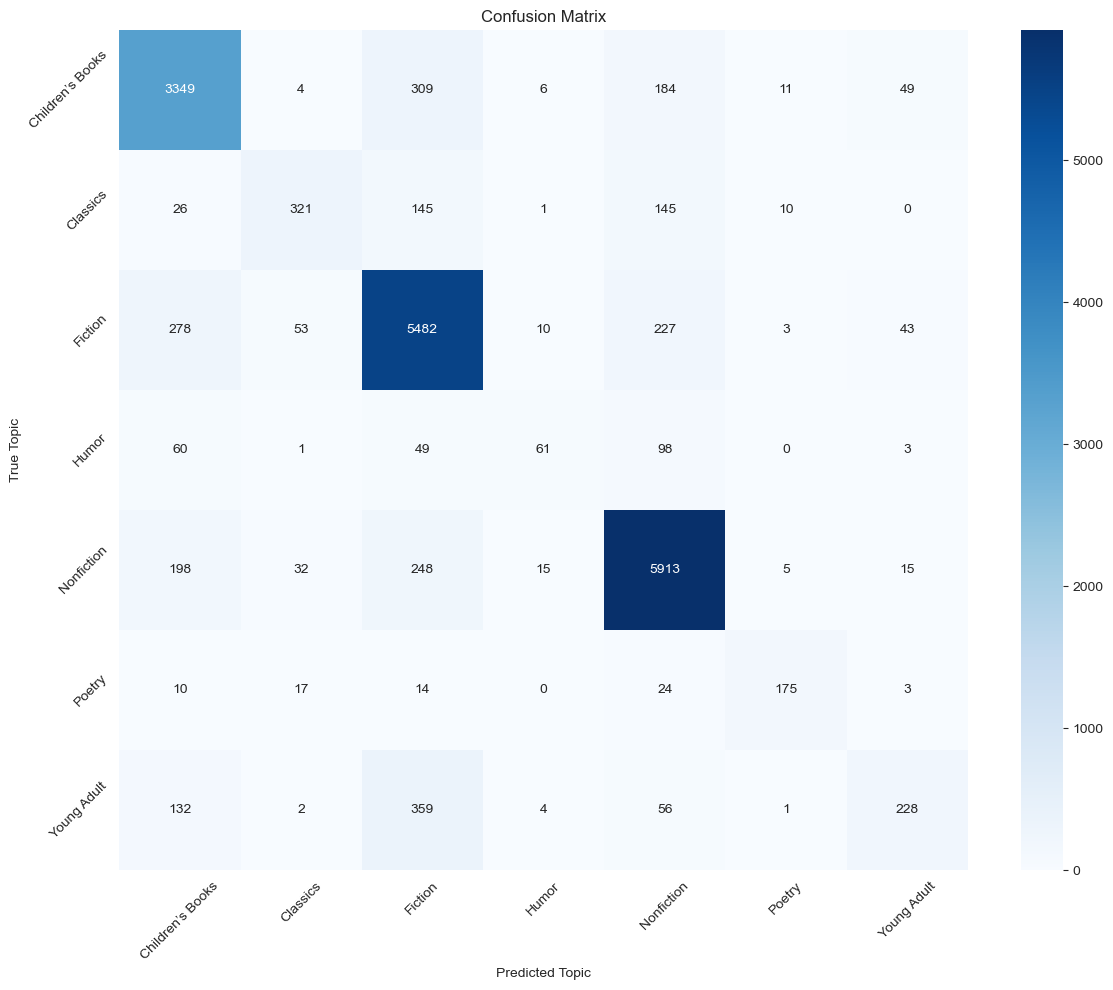

X_tfidf_spacy

Classification Report - X_tfidf_spacy:
                  precision    recall  f1-score   support

Children’s Books       0.83      0.85      0.84      3912
        Classics       0.75      0.49      0.59       648
         Fiction       0.83      0.90      0.86      6096
           Humor       0.53      0.21      0.30       272
      Nonfiction       0.88      0.92      0.90      6426
          Poetry       0.89      0.70      0.79       243
     Young Adult       0.63      0.27      0.38       782

        accuracy                           0.84     18379
       macro avg       0.76      0.62      0.67     18379
    weighted avg       0.83      0.84      0.83     18379

Macro F1-Score: 0.6650703892597744


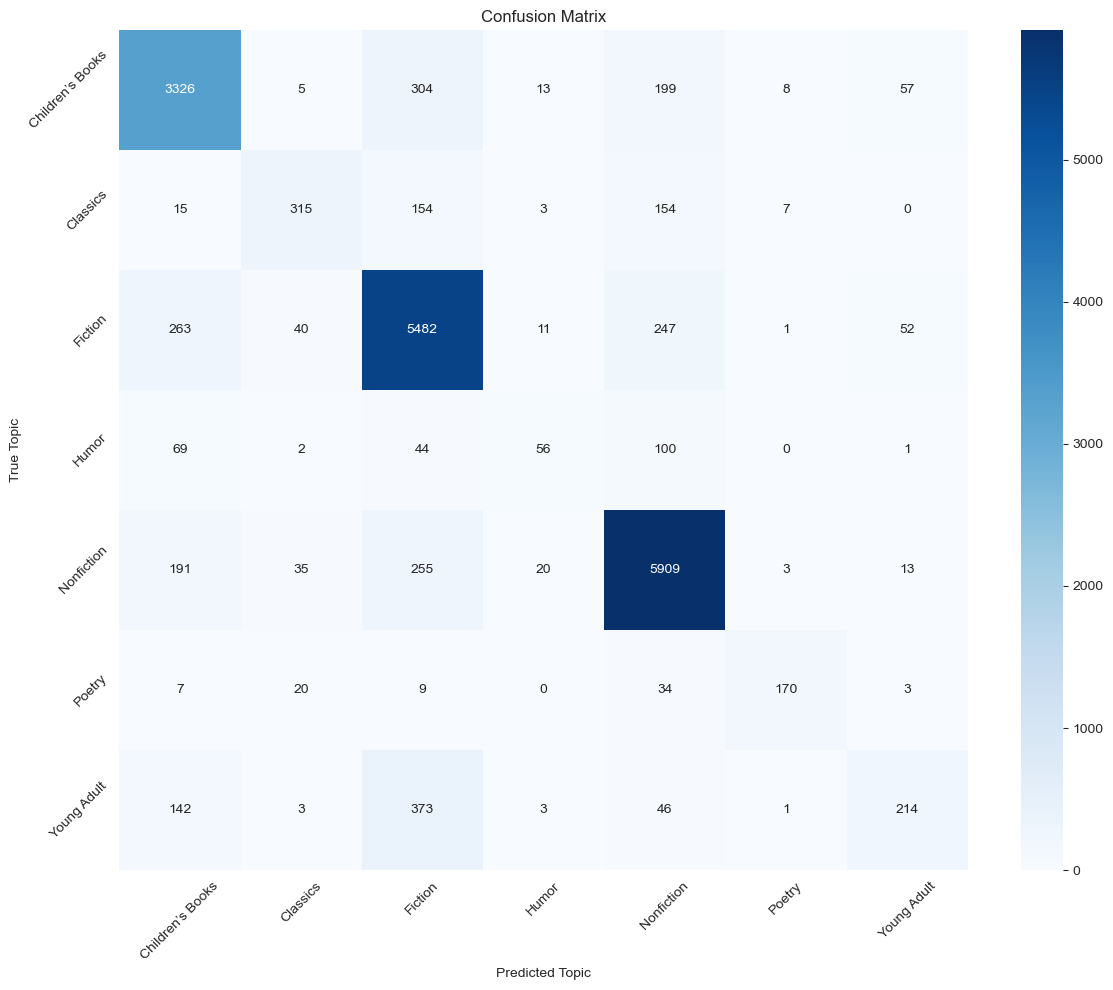

X_docvec_nltk

Classification Report - X_docvec_nltk:
                  precision    recall  f1-score   support

Children’s Books       0.73      0.75      0.74      3912
        Classics       0.52      0.27      0.36       648
         Fiction       0.75      0.83      0.79      6096
           Humor       0.50      0.27      0.35       272
      Nonfiction       0.82      0.85      0.84      6426
          Poetry       0.77      0.62      0.69       243
     Young Adult       0.54      0.23      0.32       782

        accuracy                           0.76     18379
       macro avg       0.66      0.54      0.58     18379
    weighted avg       0.75      0.76      0.75     18379

Macro F1-Score: 0.5823516773206251


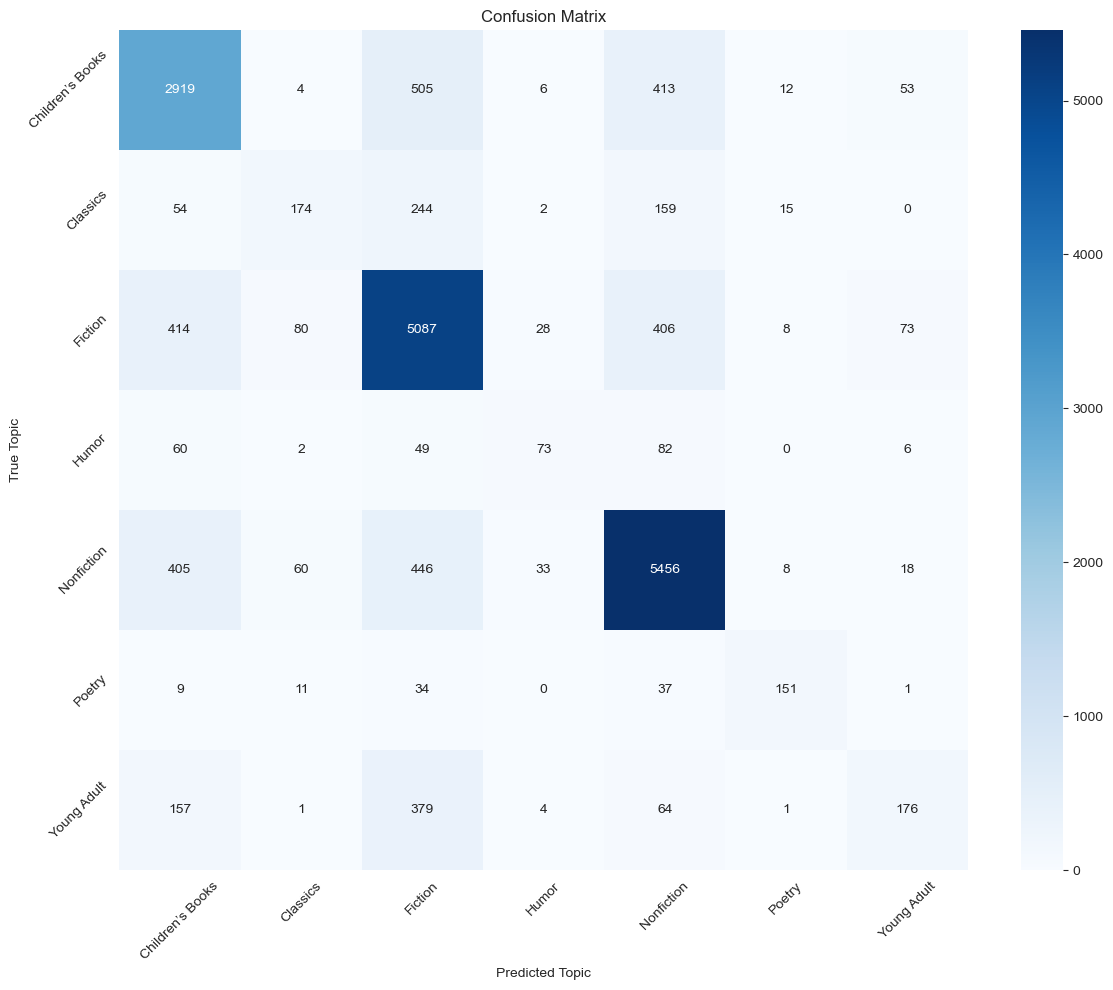

X_docvec_spacy

Classification Report - X_docvec_spacy:
                  precision    recall  f1-score   support

Children’s Books       0.71      0.71      0.71      3912
        Classics       0.50      0.24      0.32       648
         Fiction       0.74      0.83      0.78      6096
           Humor       0.50      0.25      0.34       272
      Nonfiction       0.80      0.84      0.82      6426
          Poetry       0.75      0.51      0.61       243
     Young Adult       0.54      0.20      0.29       782

        accuracy                           0.75     18379
       macro avg       0.65      0.51      0.55     18379
    weighted avg       0.73      0.75      0.73     18379

Macro F1-Score: 0.5531086204760219


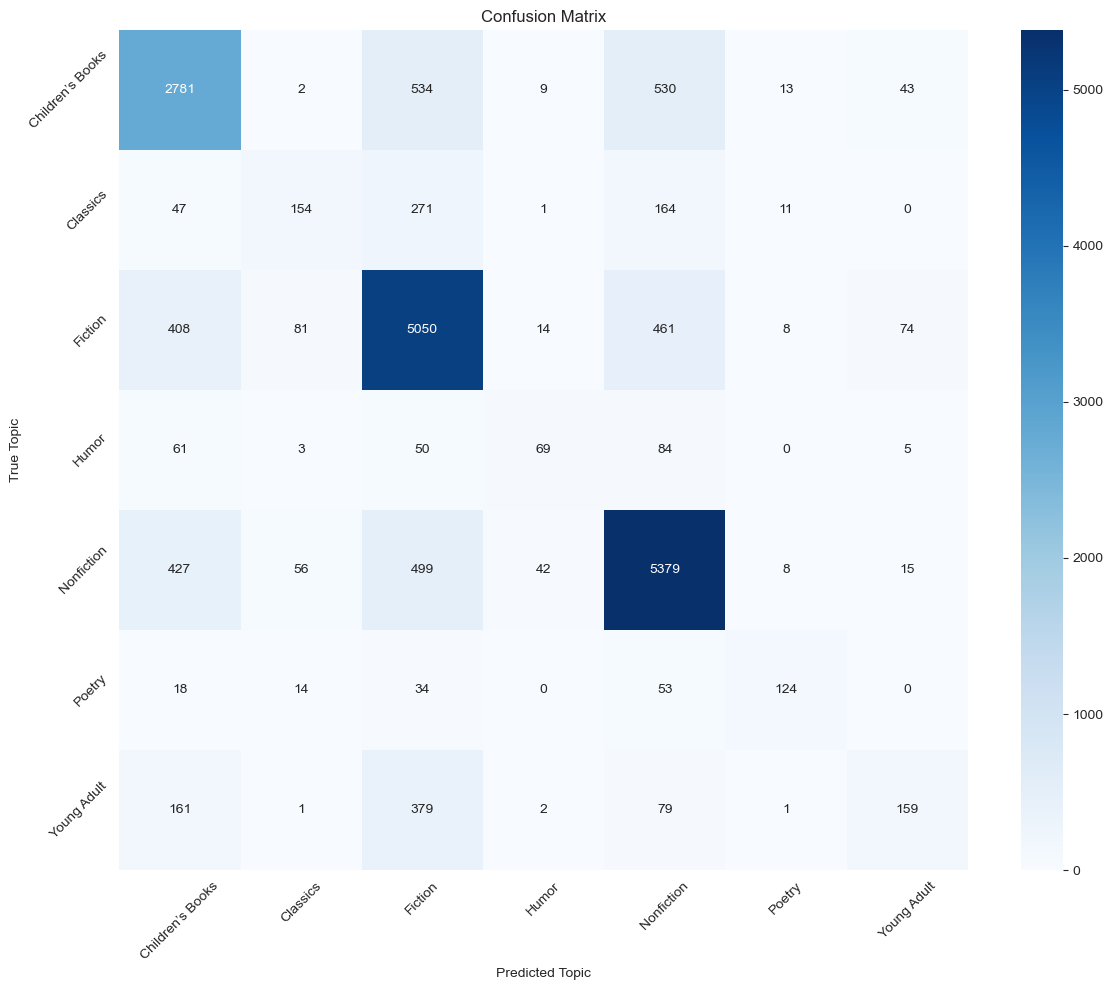

X_uce

Classification Report - X_uce:
                  precision    recall  f1-score   support

Children’s Books       0.84      0.85      0.85      3912
        Classics       0.75      0.53      0.62       648
         Fiction       0.84      0.91      0.87      6096
           Humor       0.61      0.35      0.44       272
      Nonfiction       0.90      0.92      0.91      6426
          Poetry       0.84      0.77      0.81       243
     Young Adult       0.65      0.33      0.44       782

        accuracy                           0.85     18379
       macro avg       0.78      0.67      0.70     18379
    weighted avg       0.85      0.85      0.85     18379

Macro F1-Score: 0.7046509621699814


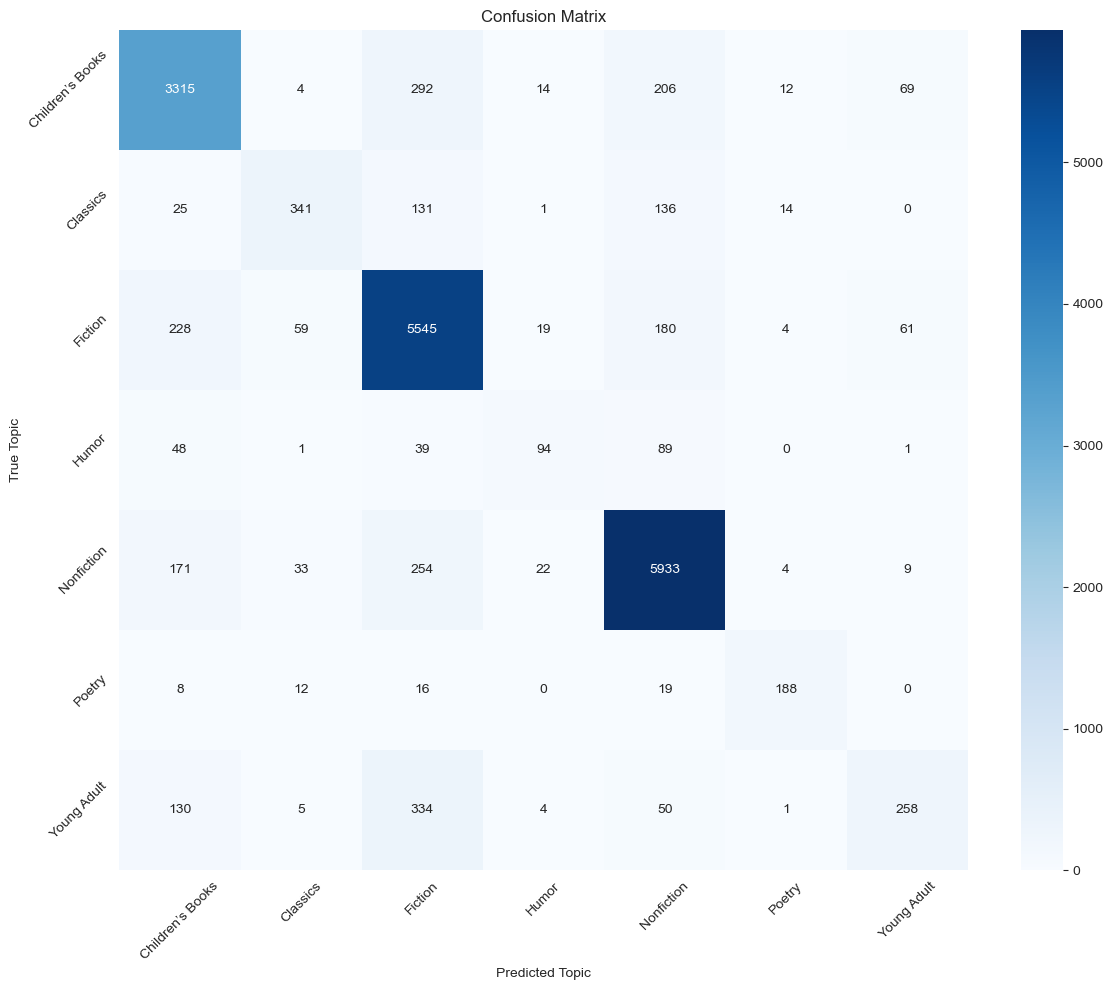

In [19]:
y = df['TOPIC_MAIN']
for title, X in (('X_tfidf_nltk', X_tfidf_nltk), ('X_tfidf_spacy', X_tfidf_spacy),
                 ('X_docvec_nltk', X_docvec_nltk), ('X_docvec_spacy', X_docvec_spacy),
                 ('X_uce', X_uce)):
    #X = X_tfidf_nltk #temp
    #title = 'X_tfidf_nltk'

    print(title)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    """print(f'Train X Size: {X_train.shape}')
    print(f'Test X Size: {X_test.shape}')
    print(f'Train Y Size: {y_train.shape}')
    print(f'Test Y Size: {y_test.shape}')"""

    # Train the classifier
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Classification Report
    print(f"\nClassification Report - {title}:")
    print(classification_report(y_test, y_pred, zero_division=1))

    # Macro F1-Score
    print("Macro F1-Score:", f1_score(y_test, y_pred, average='macro'))

    # Confusion Matrix
    labels = sorted(list(set(y_test) | set(y_pred)))
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Topic')
    plt.ylabel('True Topic')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
